# Exercise XI: Embeddings

## Part 1: Dimensionality Reduction & The Neural Manifold

### **Introduction**
An embedding is a dense representation where we specifically enforce a geometrical property: similar objects must be closer together in the latent space. This is different from standard dimensionality reduction; here, the "meaning" is learned through specific loss functions, such as contrastive learning.

A primary example of this is [**VGGish**](https://v-iashin.github.io/video_features/models/vggish/), which converts audio spectrograms into feature embeddings that a classifier can use to distinguish between complex signals, such as different types of breathing patterns.

![VGGish audio](cc3.png)

### **Key Concepts**
**Semantic Embedding**: Learning a dense representation where similar words have similar encodings.

**Encoders**: Models like [DistilBERT](https://huggingface.co/docs/transformers/en/model_doc/distilbert) (text), [VGGish](https://v-iashin.github.io/video_features/models/vggish/) (audio), or [CLIP](https://openai.com/index/clip/) (image/text) act as the "engine" that creates these vectors.

**Contrastive Alignment**: Models like CLIP align different modalities (images and text) into the same embedding space.

## **Working with Text Embeddings (DistilBERT)**
### **introduction to DistilBERT**

[DistilBERT](https://huggingface.co/docs/transformers/en/model_doc/distilbert) is a pre-trained transformer model that maps text into a 768-dimensional latent space. Each sentence is tokenized and passed through the model to produce a vector that captures its semantic essence.

We can verify the "enforced geometry" of the embedding space by calculating the Cosine Similarity between different concepts.

In [2]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# Load a pre-trained DistilBERT-based model
# This model has already 'learned' the semantic structure of language
model = SentenceTransformer('all-MiniLM-L6-v2') 

# Define stimuli categories
stimuli = ["cat", "dog", "lion", "apple", "banana", "orange"]

# 1. Generate Embeddings (Model Input -> Encoding -> Dense Vector)
embeddings = model.encode(stimuli)

# 2. Compute Similarity Matrix 
# This reveals how the model clusters 'Animals' vs 'Fruits'
sim_matrix = cosine_similarity(embeddings)

# 3. Visualize the geometry
plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix, xticklabels=stimuli, yticklabels=stimuli, annot=True, cmap='RdBu_r')
plt.title("Learned Similarity in DistilBERT Embedding Space")
plt.show()

ModuleNotFoundError: No module named 'sentence_transformers'

## **Part 2: Semantic Embeddings & Representational Similarity Analysis (RSA)**

### **Introduction**
In the previous section, we saw how embeddings can capture the "manifold" of neural population activity. In this section, we move to Semantic Embeddings, which represent the "meaning" of stimuli (such as words, images, or audio) as dense vectors.

We've previously discussed [**DistilBERT**]((https://huggingface.co/docs/transformers/en/model_doc/distilbert)), a model that transforms **text into a 768-dimensional embedding space**. In neuroscience, we use these embeddings to perform [Representational Similarity Analysis (RSA)](https://dartbrains.org/content/RSA.html)$^1$. RSA allows us to compare how a machine learning model "sees" the world versus how the brain represents the same stimuli.

![RSA](https://dartbrains.org/_images/similarity.jpg)


### **Task: Building a Semantic Similarity Matrix**
In this exercise, we will:

* Use a pre-trained transformer to generate embeddings for a set of stimulus words.

* Calculate the Cosine Similarity between these embeddings.

* Visualize the Representational Similarity Matrix (RSM) to see how the model clusters concepts.

In [39]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# 1. Load a pre-trained model (equivalent to DistilBERT logic in slides)
# This model maps sentences/words to a 384-dimensional dense vector space
model = SentenceTransformer('all-MiniLM-L6-v2') 

# 2. Define our stimuli (Neuroscience experiment categories)
stimuli = [
    "cat", "dog", "lion",         # Animals
    "apple", "banana", "orange",  # Fruits
    "car", "truck", "train"       # Vehicles
]

# 3. Generate the embeddings
# Each word becomes a vector (Model Input -> Model Output)
embeddings = model.encode(stimuli)

print(f"Number of stimuli: {len(stimuli)}")
print(f"Embedding dimension: {embeddings.shape[1]}")

Number of stimuli: 9
Embedding dimension: 384


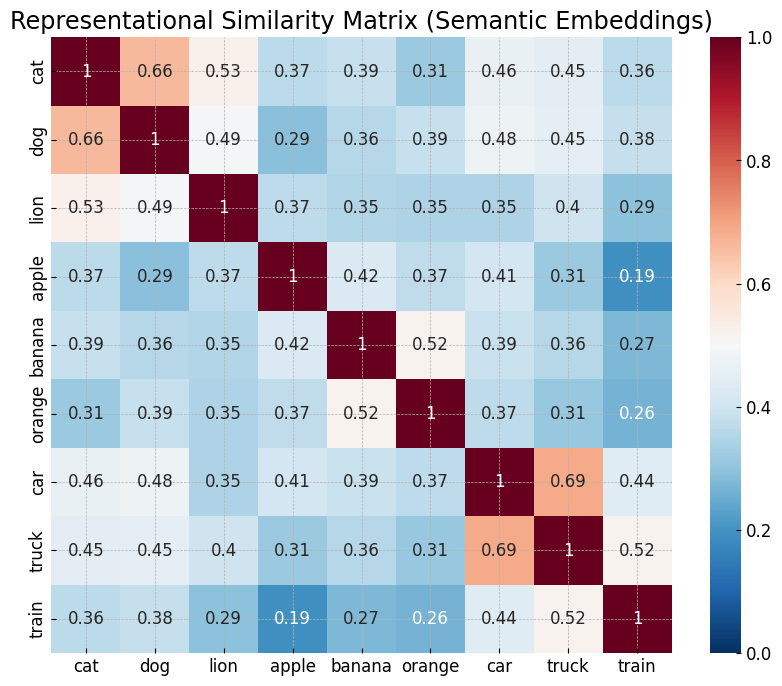

In [40]:
# 4. Compute the Cosine Similarity Matrix
# This tells us how "similar" each word vector is to every other vector
rsm = cosine_similarity(embeddings)

# 5. Plot the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(rsm, annot=True, xticklabels=stimuli, yticklabels=stimuli, 
            cmap='RdBu_r', vmin=0, vmax=1)

plt.title("Representational Similarity Matrix (Semantic Embeddings)")
plt.show()

## **Supervised Decoding - Predicting from Embeddings**
### **Introduction**
Once we have these learned features, we can use them as inputs for supervised models (e.g., Logistic Regression). In this section, we predict the sentiment of a sentence based solely on its position in the embedding space.


### **Task: Sentiment Analysis on the SST-2 Dataset**
We will use samples from an open-source sentiment dataset to train a classifier.

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/stanfordnlp/sst2/" + splits["train"])

# sample 3000 rows for demo purposes
df = df.sample(n=3000, random_state=42).reset_index(drop=True)

# 1. Prepare a small labeled dataset for sentiment analysis
sentences = df['sentence'].tolist()
y = df['label'].tolist()  # 0 = negative, 1 = positive

# demonstrate "positive" and "negative" examples
rand_pos = df[df['label'] == 1]['sentence'].sample(3).values
rand_neg = df[df['label'] == 0]['sentence'].sample(3).values

print("Positive Examples:")
for sent in rand_pos:
    print(f" - {sent}")
print("\nNegative Examples:")
for sent in rand_neg:
    print(f" - {sent}")


Positive Examples:
 - to cut a swathe through mainstream hollywood 
 - with this one too 
 - cinematography to the outstanding soundtrack and unconventional narrative 

Negative Examples:
 - the human race splitting in two 
 - your favorite pet get buried alive 
 - a sketchy work-in-progress 


In [42]:

# 2. Generate Embeddings (768 dimensions per sentence)
print("Generating embeddings for 3000 SST-2 samples...")
transformer = SentenceTransformer('all-MiniLM-L6-v2') 
X_embeddings = transformer.encode(sentences)

print(f"Feature Matrix Shape: {X_embeddings.shape} (Samples, Embedding Dim)")

Generating embeddings for 3000 SST-2 samples...
Feature Matrix Shape: (3000, 384) (Samples, Embedding Dim)


Text(0.5, 1.0, 'ROC Curve for Sentiment Decoding')

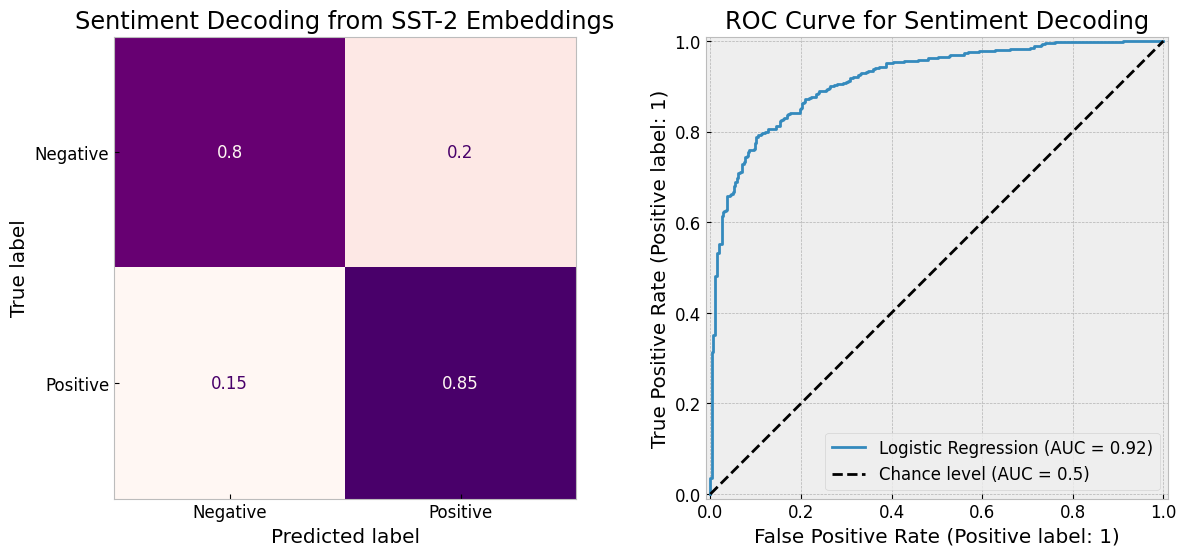

In [46]:
# 3. Split into Training and Testing sets (75% / 25%)
from sklearn.metrics import ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(
    X_embeddings, y, test_size=0.25, stratify=y, random_state=42
)

# 4. Train a Logistic Regression Classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# 5. Evaluate the results
y_pred = clf.predict(X_test)

# 6. Visualize the Confusion Matrix and ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, 
                                      display_labels=['Negative', 'Positive'], 
                                      cmap='RdPu',
                                      normalize='true',
                                      ax=axes[0],
                                      colorbar=False
                                      )
axes[0].set_title("Sentiment Decoding from SST-2 Embeddings")
axes[0].grid(False)

from sklearn.decomposition import PCA
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=axes[1], name='Logistic Regression', plot_chance_level=True)
axes[1].set_title("ROC Curve for Sentiment Decoding")



### **Note: From Mathematical Embeddings to Neural Representations (RSA)**
#### Embeddings as a Simulation of Semantic Similarity
In this course, we treat embeddings as a mathematical approach trying to simulate the "similarity" in the way the brain processes objects of similar context or semantics. While raw brain activity (e.g., fMRI or ECoG) is a biological response, machine learning models use specific loss functions to enforce a geometrical structure where meaningful relationships are preserved in the distance between vectors.

**Representational Similarity Analysis (RSA)**:

To test if these mathematical simulations match the brain, we use Representational Similarity Analysis (RSA).

**Model Similarity**: We create a similarity matrix (like in Part 2) showing how the model represents a set of stimuli.

**Brain Similarity**: We create a second similarity matrix based on neural responses to those same stimuli.

**Comparison**: We correlate these two matrices. A high correlation suggests that the machine embedding captures a "brain-like" representation of the information.

#### ⚠️ A Final Distinction

**Neural Activity**: This is the raw biological signal. We do not automatically call it an "embedding" unless we have demonstrated that it satisfies learned geometrical properties.

**Machine Embeddings**: These are engineered features. We use them as a proxy or a hypothesis of how the brain might be organizing information.